## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

D:\Program Files\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
    return model

In [10]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [11]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.75]
redice_lr_patient = [5, 10, 25]

In [12]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1) 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 7s 143us/step - loss: 1.3103 - acc: 0.5446 - val_loss: 1.5072 - val_acc: 0.4708
Epoch 12/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.2864 - acc: 0.5552 - val_loss: 1.4969 - val_acc: 0.4762
Epoch 13/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.2644 - acc: 0.5621 - val_loss: 1.4866 - val_acc: 0.4763
Epoch 14/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.2415 - acc: 0.5703 - val_loss: 1.4817 - val_acc: 0.4793
Epoch 15/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.2207 - acc: 0.5777 - val_loss: 1.4734 - val_acc: 0.4829
Epoch 16/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.1993 - acc: 0.5864 - val_loss: 1.4675 - val_acc: 0.4909
Epoch 17/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.1797 - acc: 0.5931 - val_loss: 1.4598 - val_acc: 0.4909
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 169us/step - loss: 2.2822 - acc: 0.2549 - val_loss: 2.2998 - val_acc: 0.2941
Epoch 2/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.7759 - acc: 0.3828 - val_loss: 1.9164 - val_acc: 0.3553
Epoch 3/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.6390 - acc: 0.4291 - val_loss: 1.7316 - val_acc: 0.4019
Epoch 4/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.5619 - acc: 0.4533 - val_loss: 1.6520 - val_acc: 0.4232
Epoch 5/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.5069 - acc: 0.4734 - val_loss: 1.6148 - val_acc: 0.4377
Epoch 6/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.4614 - acc: 0.4897 - val_loss: 1.5792 - val_acc: 0.4468
Epoch 7/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.4238 - acc: 0.5040 - val_loss: 1.5479 - 

50000/50000 [==============================] - 7s 144us/step - loss: 1.1531 - acc: 0.6019 - val_loss: 1.4757 - val_acc: 0.4858
Epoch 24/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.1376 - acc: 0.6084 - val_loss: 1.4676 - val_acc: 0.4892
Epoch 25/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.1232 - acc: 0.6139 - val_loss: 1.4670 - val_acc: 0.4920
Numbers of exp: 5, reduce_factor: 0.75, reduce_patient: 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_l

Epoch 10/25
50000/50000 [==============================] - 7s 148us/step - loss: 0.9147 - acc: 0.6860 - val_loss: 1.4188 - val_acc: 0.5006
Epoch 11/25
50000/50000 [==============================] - 8s 152us/step - loss: 0.8795 - acc: 0.6998 - val_loss: 1.5249 - val_acc: 0.4812
Epoch 12/25
50000/50000 [==============================] - 7s 149us/step - loss: 0.8439 - acc: 0.7121 - val_loss: 1.5482 - val_acc: 0.4702
Epoch 13/25
50000/50000 [==============================] - 8s 150us/step - loss: 0.8182 - acc: 0.7197 - val_loss: 1.5319 - val_acc: 0.4865
Epoch 14/25
50000/50000 [==============================] - 8s 150us/step - loss: 0.7816 - acc: 0.7349 - val_loss: 1.7433 - val_acc: 0.4563
Epoch 15/25
50000/50000 [==============================] - 7s 147us/step - loss: 0.7537 - acc: 0.7456 - val_loss: 1.5581 - val_acc: 0.4826

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16/25
50000/50000 [==============================] - 8s 152us/step - loss: 0.66

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 211us/step - loss: 1.8799 - acc: 0.3543 - val_loss: 1.7911 - val_acc: 0.3862
Epoch 2/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.5450 - acc: 0.4577 - val_loss: 1.6340 - val_acc: 0.4303
Epoch 3/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.4453 - acc: 0.4930 - val_loss: 1.6193 - val_acc: 0.4336
Epoch 4/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.3802 - acc: 0.5161 - val_loss: 1.5477 - val_acc: 0.4489
Epoch 5/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.3305 - acc: 0.5349 - val_loss: 1.5419 - val_acc: 0.4587
Epoch 6/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.2883 - acc: 0.5492 - val_loss: 1.5632 - val_acc: 0.4524
Epoch 7/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.2536 - acc: 0.5631 - val_loss: 1.4703 -

50000/50000 [==============================] - 8s 153us/step - loss: 0.8744 - acc: 0.7101 - val_loss: 1.4028 - val_acc: 0.5105
Epoch 24/25
50000/50000 [==============================] - 7s 149us/step - loss: 0.8602 - acc: 0.7177 - val_loss: 1.4012 - val_acc: 0.5135
Epoch 25/25
50000/50000 [==============================] - 8s 153us/step - loss: 0.8478 - acc: 0.7233 - val_loss: 1.3989 - val_acc: 0.5128
Numbers of exp: 10, reduce_factor: 0.75, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_

50000/50000 [==============================] - 8s 150us/step - loss: 1.2056 - acc: 0.5826 - val_loss: 1.4616 - val_acc: 0.4916
Epoch 11/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.1821 - acc: 0.5924 - val_loss: 1.4355 - val_acc: 0.4981
Epoch 12/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.1600 - acc: 0.6009 - val_loss: 1.4290 - val_acc: 0.4979
Epoch 13/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.1405 - acc: 0.6077 - val_loss: 1.4476 - val_acc: 0.4931
Epoch 14/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.1217 - acc: 0.6150 - val_loss: 1.4256 - val_acc: 0.4984
Epoch 15/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.1038 - acc: 0.6212 - val_loss: 1.4300 - val_acc: 0.4978
Epoch 16/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.0848 - acc: 0.6298 - val_loss: 1.4221 - val_acc: 0.5035
Epoch 17/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 213us/step - loss: 1.8596 - acc: 0.3607 - val_loss: 1.9544 - val_acc: 0.3382
Epoch 2/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.5577 - acc: 0.4563 - val_loss: 2.2701 - val_acc: 0.3048
Epoch 3/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.4415 - acc: 0.4960 - val_loss: 1.8182 - val_acc: 0.3863
Epoch 4/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.3634 - acc: 0.5254 - val_loss: 1.6718 - val_acc: 0.4290
Epoch 5/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.3031 - acc: 0.5462 - val_loss: 2.2973 - val_acc: 0.3176
Epoch 6/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.2505 - acc: 0.5656 - val_loss: 1.8667 - val_acc: 0.3826
Epoch 7/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.2036 - acc: 0.5838 - val_loss: 1.7418 -

50000/50000 [==============================] - 8s 154us/step - loss: 0.8543 - acc: 0.7157 - val_loss: 1.5530 - val_acc: 0.4791
Epoch 24/25
50000/50000 [==============================] - 8s 151us/step - loss: 0.8353 - acc: 0.7219 - val_loss: 1.6731 - val_acc: 0.4497
Epoch 25/25
50000/50000 [==============================] - 7s 149us/step - loss: 0.8156 - acc: 0.7274 - val_loss: 1.6776 - val_acc: 0.4482
Numbers of exp: 15, reduce_factor: 0.75, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_l

50000/50000 [==============================] - 8s 150us/step - loss: 1.3181 - acc: 0.5435 - val_loss: 1.5229 - val_acc: 0.4597
Epoch 10/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.2881 - acc: 0.5533 - val_loss: 1.5319 - val_acc: 0.4616
Epoch 11/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.2601 - acc: 0.5640 - val_loss: 1.5024 - val_acc: 0.4753
Epoch 12/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.2334 - acc: 0.5735 - val_loss: 1.5551 - val_acc: 0.4615
Epoch 13/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.2090 - acc: 0.5838 - val_loss: 1.4890 - val_acc: 0.4819
Epoch 14/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.1850 - acc: 0.5917 - val_loss: 1.5054 - val_acc: 0.4729
Epoch 15/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.1624 - acc: 0.6001 - val_loss: 1.4901 - val_acc: 0.4814
Epoch 16/25
50000/50000 [==============

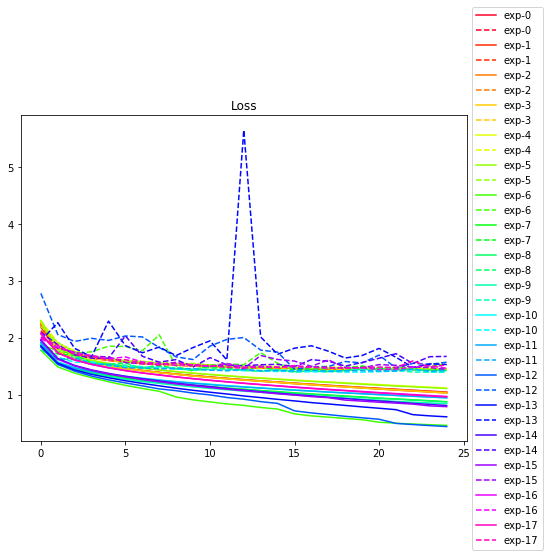

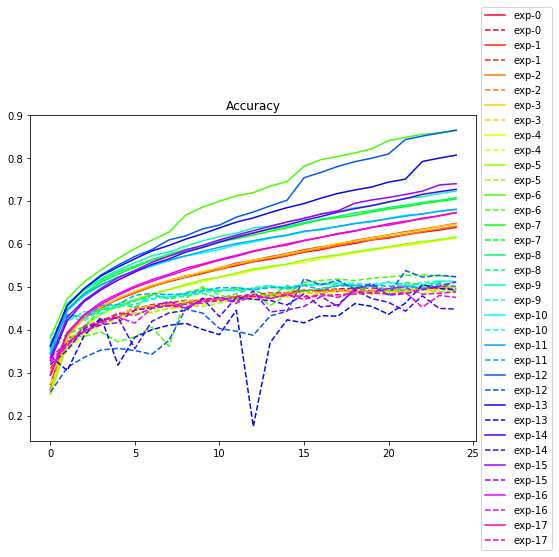

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()